In [ ]:
!wget -O image.jpg https://bizweb.dktcdn.net/thumb/1024x1024/100/347/446/products/bo-hoa-hong-do-dep-bo-hoa-hong-do-nhap-khau.jpg?v=1564829027417
!wget -O image.png https://www.pyimagesearch.com/wp-content/uploads/2016/10/omr_test_01.png

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [33]:
class Homogenous:
  def __init__(self):
    pass
  def get_transform_matrix(self, kind, param, point=None):
    if kind == 'rotate':
      theta = param
      if point != None:
        a,b = point
        return np.array([
            [np.cos(theta), -np.sin(theta), a + b*np.sin(theta) - a*np.cos(theta)],
            [np.sin(theta), np.cos(theta), b - b*np.cos(theta) - a*np.sin(theta)],
            [0          , 0             , 1]
        ])
      return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    elif kind == 'translate':
      dx, dy = param
      return np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]])
    elif kind == 'scale':
      sx, sy = param
      return np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])
    elif kind == 'shear':
      dx, dy, theta = param
      if dx == 1 and dy == 0:
        return np.array([[1, 1/np.tan(theta), 0], [0, 1, 0], [0, 0, 1]])
      elif dx == 0 and dy == 1:
        return np.array([[1, 0, 0], [1/np.tan(theta), 1, 0], [0, 0, 1]])
      else:
        raise Exception('dx or dy should be defferent from 0')
  def process(self, image, M):
    M = np.linalg.inv(M)
    ret = np.ones_like(image)
    height, width = image.shape[:2]
    coords = np.indices((width, height)).reshape(2, -1)
    coords = np.vstack((coords, np.ones((1, coords.shape[1])))).astype(np.int32)
    corr_coords = M.dot(coords).astype(np.int32)
    ids =  np.where(np.logical_and(np.logical_and(corr_coords[0] >= 0, corr_coords[0] < width), np.logical_and(corr_coords[1] >= 0, corr_coords[1] < height)))
    ret[coords[1, ids], coords[0, ids]] = image[corr_coords[1, ids], corr_coords[0, ids]]
    return ret

  def rotate(self, image, theta, point=None):
    theta = theta * np.pi / 180
    M = self.get_transform_matrix('rotate', theta, point)
    return self.process(image, M)
  def translate(self, image, dx=0, dy=0):
    M = self.get_transform_matrix('translate', (dx,dy))
    return self.process(image, M)
  def scale(self, image, sx=0, sy=0):
    M = self.get_transform_matrix('scale', (sx,sy))
    return self.process(image, M)
  def shear(self, image, theta, dx=0, dy=0):
    theta = theta * np.pi / 180
    M = None
    if dx == 1:
      M = self.get_transform_matrix('shear', (1,0,theta))
    if dy == 1:
      M = self.get_transform_matrix('shear', (0, 1, theta))   if M is None else M.dot(self.get_transform_matrix('shear', (0, 1, theta)))
    return self.process(image, M) if type(M) != None else image
  
  def get_equation(self, point1, point2):
    '''
    * Return value:
      - equation: shape(2, 8)
      - result_column: shape(2,1)
    '''
    x1, y1 = np.float32(point1)
    x2, y2 = np.float32(point2)
    equation = np.zeros((2, 8))
    equation[0, :3] = x1, y1, 1
    equation[0, -2:] = x1 * x2, y1 * x2
    equation[1, 3:6] = x1, y1, 1
    equation[1, -2:] = x1 * y2, y1 * y2
    return equation, np.array(point2).reshape(2,1)

  def restore_perspective(self, img, corner, transform_corner, forloop=False):
    A = np.array([]).reshape(0,8)
    C = np.array([]).reshape(0,1)
    result = np.zeros_like(img)
    for point1, point2 in zip(corner, transform_corner):
      equation = self.get_equation(point1, point2)
      A = np.vstack((A, equation[0]))
      C = np.vstack((C, equation[1]))
    
    M = np.float16(np.linalg.inv(A).dot(C))
    M = np.vstack((M,np.ones((1,1)))).reshape(3,3)

    start_time = time.time()
    if forloop:
      for r in range(HEIGHT):
        for c in range(WIDTH):
          translated_pos = np.array([c,r,1]).reshape(3,1)
          origion_pos = np.linalg.inv(M).dot(translated_pos)
          x, y = np.int16(origion_pos[:2, 0])
          result[r,c] = img[y,x]
    else:
      result = self.process(img, M)
    end_time = time.time()
    print('{1} ran in {0}'.format(end_time - start_time, 'With Forloop' if forloop else 'Without Forloop'))
    return result


In [34]:
hom = Homogenous()
image = cv2.imread('image.jpg')

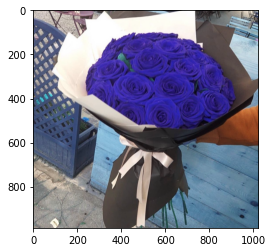

In [13]:
plt.imshow(image)

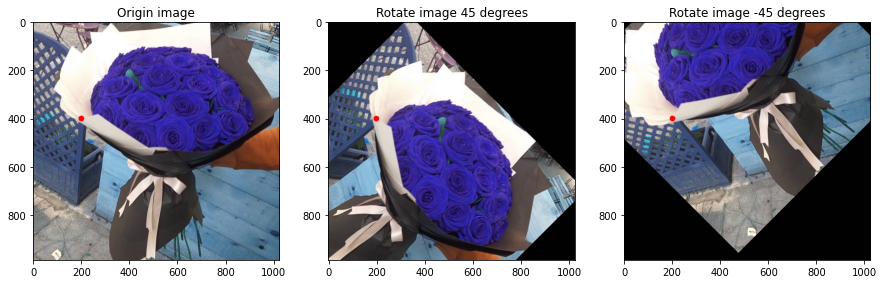

In [16]:
point = (200, 400)

temp = image.copy()
cv2.circle(temp, point, 12, (255,0,0), -1)

rotate_up_img = hom.rotate(temp, 45, point)
rotate_down_img = hom.rotate(temp, -45, point)

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 5)
ax[0].imshow(temp)
ax[0].set_title('Origin image')

ax[1].imshow(rotate_up_img)
ax[1].set_title('Rotate image 45 degrees')

ax[2].imshow(rotate_down_img)
ax[2].set_title('Rotate image -45 degrees')

fig.show()


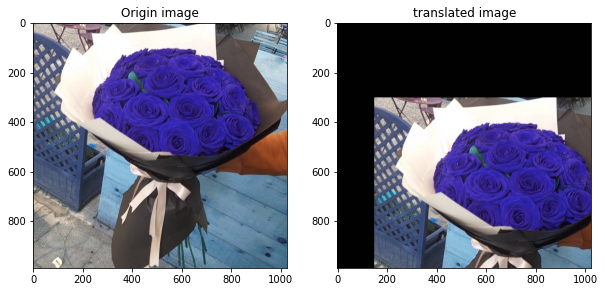

In [17]:
translate_img = hom.translate(image, 150, 300)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax[0].imshow(image)
ax[0].set_title('Origin image')

ax[1].imshow(translate_img)
ax[1].set_title('translated image')

fig.show()


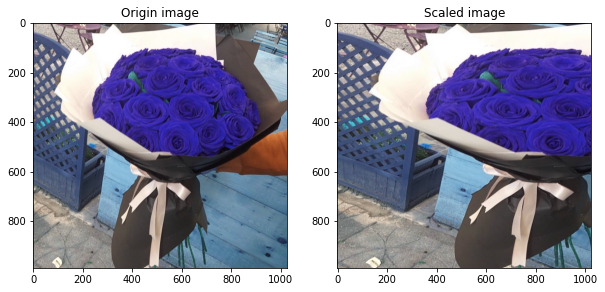

In [18]:
scaled_img = hom.scale(image, 1.5, 1)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax[0].imshow(image)
ax[0].set_title('Origin image')

ax[1].imshow(scaled_img)
ax[1].set_title('Scaled image')

fig.show()


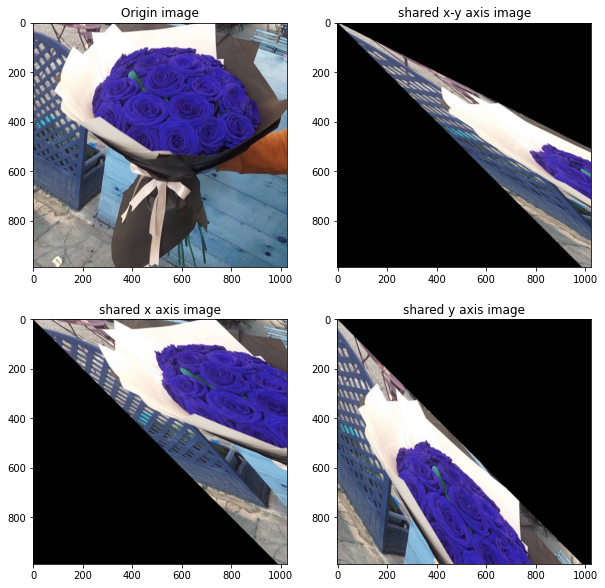

In [20]:
sheared_x_img = hom.shear(image, 45, 1, 0)
sheared_y_img = hom.shear(image, 45, 0, 1)
sheared_img = hom.shear(image, 45, 1, 1)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10, 10)

ax[0,0].imshow(image)
ax[0,0].set_title('Origin image')

ax[0,1].imshow(sheared_img)
ax[0,1].set_title('shared x-y axis image')

ax[1,0].imshow(sheared_x_img)
ax[1,0].set_title('shared x axis image')

ax[1,1].imshow(sheared_y_img)
ax[1,1].set_title('shared y axis image')

fig.show()


With Forloop ran in 11.255897045135498
Without Forloop ran in 0.06238198280334473


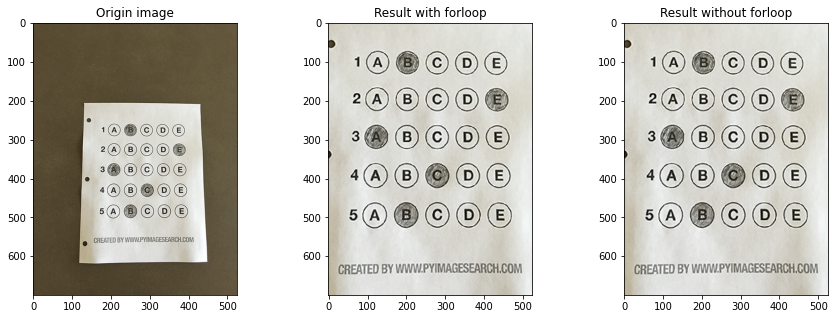

In [36]:
img = cv2.imread('image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
HEIGHT, WIDTH = img.shape[:2]
corner = [(132, 210), (431, 212), (451, 617), (120,620)]
transform_corner = [(0,0), (WIDTH, 0), (WIDTH, HEIGHT), (0, HEIGHT)]

ret_forloop = hom.restore_perspective(img, corner, transform_corner, forloop=True)
ret_no_forloop = hom.restore_perspective(img, corner, transform_corner)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

ax[0].imshow(img)
ax[0].set_title('Origin image')
ax[1].imshow(ret_forloop)
ax[1].set_title('Result with forloop')
ax[2].imshow(ret_no_forloop)
ax[2].set_title('Result without forloop')

fig.show()